In [17]:
import pandas as pd
import numpy as np
import glob
import re
import swifter
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from simpletransformers.ner import NERModel,NERArgs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
def remove_punct(word):
    res = re.sub(r'[^\w\s\%,\-\@:]', '', word)
    return res

In [19]:
def fix_percent(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == '%' and words[i-1].isnumeric():
                fixed += 1
                labels[i-1] = 'B-QUANTITY-PER'
                labels[i] = 'I-QUANTITY-PER'
    print(fixed)
    return words, labels

In [20]:
def fix_gb(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == 'GB' and words[i-1].isnumeric():
                fixed += 1
                labels[i-1] = 'B-QUANTITY-NUM'
                labels[i] = 'I-QUANTITY-NUM'
    print(fixed)
    return words, labels

In [21]:
def fix_distance(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] in ['cm', 'mm', 'km', 'm'] and words[i-1].isnumeric():
                if labels[i] == 'O':
                    fixed += 1
                    labels[i-1] = 'B-QUANTITY-DIM'
                    labels[i] = 'I-QUANTITY-DIM'
    print(fixed)
    return words, labels

In [22]:
def fix_distance_vie(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if i + 1 < len(words):
                if words[i] in ['triệu', 'nghìn', 'ngàn', 'tỉ', 'tỷ'] and words[i-1].isnumeric() and words[i+1] in ['cm', 'mm', 'km', 'm']:
                    fixed += 1
                    labels[i-1] = 'B-QUANTITY-DIM'
                    labels[i] = 'I-QUANTITY-DIM'
                    labels[i+1] = 'I-QUANTITY-DIM'
    print(fixed)
    return words, labels

In [23]:
def fix_currency_vie(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if i + 1 < len(words):
                if words[i] in ['triệu', 'nghìn', 'ngàn', 'tỉ', 'tỷ'] and words[i-1].isnumeric() and words[i+1] in ['đồng', "USD", 'euro']:
                    fixed += 1
                    labels[i-1] = 'B-QUANTITY-CUR'
                    labels[i] = 'I-QUANTITY-CUR'
                    labels[i+1] = 'I-QUANTITY-CUR'
    print(fixed)
    return words, labels

In [24]:
def fix_age(words, labels):
    fixed = 0
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if words[i] == 'tuổi' and words[i-1].isnumeric():
                fixed += 1
                labels[i-1] = 'B-QUANTITY-AGE'
                labels[i] = 'I-QUANTITY-AGE'
    print(fixed)
    return words, labels

In [25]:
def fix_datetime_date(words, labels):
    fixed = 0
    pattern_datetime_date = re.compile("^([0-9]|0[1-9]|1\d|2\d|3[0-1])(\/|\.|-)(0[1-9]|1\d|\d)|((\/|\.|-)(19|20)\d{2}$)")
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if pattern_datetime_date.match(words[i]) and (labels[i] == 'O'):
                if words[i].replace(':', '').replace('/', '').replace('-', '').isnumeric():
                    fixed += 1
                    if words[i-1].lower() in ['ngày', 'chiều', 'tối', 'sáng', 'trưa']:
                        labels[i-1] = 'B-DATETIME-DATE'
                        labels[i] = 'I-DATETIME-DATE'
                    else:
                        labels[i] = 'B-DATETIME-DATE'
                else:
                    continue
#     for key, value in zip(words, labels):
#         print(key, value)
    print(fixed)
    return words, labels

In [26]:
def fix_datetime_time(words, labels):
    fixed = 0
    pattern_datetime_time = re.compile("^([0-1]?[0-9]|2[0-3])(:|h)([0-5][]0-9])")
    for i in range(len(words)):
        if i == 0:
            continue
        else:
            if pattern_datetime_time.match(words[i]) and labels[i] == 'O':
                fixed += 1
                labels[i] = 'B-DATETIME-TIME'
#     for key, value in zip(words, labels):
#         print(key, value)
    print(fixed)
    return words, labels

In [1]:
def pre_process(data):
    xxx = data
    Sentence = []
    Word = []
    POS = []
    Phrase = []
    NER_main = []
    Ner_extension = []
    sent_idx = 0
    files = glob.glob(f"./dataset/{data}/*.conll")

    for file in files:
        # print(file)
        with open(file, 'r') as f:
            full_text = f.readlines()
            for i in range(len(full_text)):
                full_text[i] = full_text[i].split('\t')
                if '.' in full_text[i] and '\n' in full_text[i + 1]:
                    sent_idx += 1
                elif '.' in full_text[i] and full_text[i + 1][0][0].isupper():
                    print(full_text[i + 1])
                    asdasd
                    sent_idx += 1
                elif '\n' in full_text[i]:
                    sent_idx += 1
                else:
                    Sentence.append(sent_idx)
                    Word.append(full_text[i][0].replace('\ufeff', ''))
                    POS.append(full_text[i][1])
                    Phrase.append(full_text[i][2])

                    if len(full_text[i]) >= 4:
                        NER_main.append(full_text[i][3].replace('\n', ''))
                    else:
                        NER_main.append('O')

                    if len(full_text[i]) == 5:
                        Ner_extension.append(full_text[i][4].replace('\n', ''))
                    else:
                        Ner_extension.append('O')
        
    data = pd.DataFrame.from_dict({'Sentence': Sentence,'Word': Word, 'NER_main': NER_main, \
                                    'Ner_extension': Ner_extension})
    X = data[["Sentence","Word"]]
    Y = data["NER_main"]
    
    data = pd.DataFrame({"sentence_id":X["Sentence"],"words":X["Word"],"labels":Y})
    data['words'] = data['words'].swifter.apply(remove_punct)
    data = data[data['words'] != '']
    
    # fix percent
    sentence_id = data.sentence_id.tolist()
    words = data.words.tolist()
    labels = data.labels.tolist()
    
    if xxx == 'train':
        print('fix train')
        words, labels = fix_percent(words, labels)
        words, labels = fix_gb(words, labels)
        words, labels = fix_distance(words, labels)
        words, labels = fix_age(words, labels)
        words, labels = fix_distance_vie(words, labels)
        words, labels = fix_currency_vie(words, labels)
        words, labels = fix_datetime_date(words, labels)
        words, labels = fix_datetime_time(words, labels)
    data = pd.DataFrame.from_dict({'sentence_id': sentence_id, 'words': words, 'labels': labels})
    return data

In [28]:
train = pre_process('train')

Pandas Apply:   0%|          | 0/626542 [00:00<?, ?it/s]

adsasd
426
9
8
291
0
380
157
2


In [29]:
dev = pre_process('dev')
test = pre_process('test')

Pandas Apply:   0%|          | 0/121897 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255120 [00:00<?, ?it/s]

In [32]:
all_data = pd.concat([train, dev, test])

In [2]:
label = all_data["labels"].unique().tolist()

NameError: name 'all_data' is not defined

In [34]:
args = NERArgs()
args.num_train_epochs = 2
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 32
args.eval_batch_size = 32
args.classification_report = True
# args.wandb_project = 'hieunm'
args.manual_seed = 2927
# "args.max_seq_length = 100

In [35]:
model = NERModel('roberta', 'xlm-roberta-base',labels=label, args=args, use_cuda=True, cuda_device=1)

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model c

In [36]:
# CUDA_LAUNCH_BLOCKING=1

In [37]:
model.train_model(train, eval_data = dev, acc=accuracy_score, output_dir='/data/hieunm/report.txt')

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/666 [00:00<?, ?it/s]

/data/hieunm/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 2:   0%|          | 0/666 [00:00<?, ?it/s]

(1332, 0.32486015092861187)

In [38]:
result, model_outputs, preds_list = model.eval_model(test, output_dir='/data/hieunm/')

  0%|          | 0/16 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/238 [00:00<?, ?it/s]

/data/hieunm/anaconda3/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
result

{'eval_loss': 0.2229037222984646,
 'precision': 0.5446079092995006,
 'recall': 0.5485318107667211,
 'f1_score': 0.5465628174737556}

In [28]:
prediction, model_output = model.predict(["ngày 13/7/2020, tai nạn xảy ra"])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
(prediction[0])

NameError: name 'prediction' is not defined

In [41]:
def make_report(true_df, preds_list):
    true_df.reset_index(drop=True, inplace= True)
    print('test size:', true_df.shape)
    def_feature = pd.DataFrame()
    def_feature['collect_words'] = true_df.groupby('sentence_id')['words'].apply(list)
    def_feature['collect_label'] = true_df.groupby('sentence_id')['labels'].apply(list)
    def_feature['count_words'] = def_feature.apply(lambda row: len(row.collect_words), axis=1)
    def_feature.reset_index(drop=True, inplace= True)
  
    x = []
    for sen in preds_list :
        len_sen = len(sen)
        x.append([sen,len_sen])
    df_preds = pd.DataFrame(x, columns = ['collect_words_pred','count_words_pred'])

    df_union=pd.concat([df_preds, def_feature], axis=1)

    df_union_dif =df_union[df_union.count_words_pred != df_union.count_words]
    print('diff sentence: ', df_union_dif.shape)

    df_same_length =df_union[df_union.count_words_pred == df_union.count_words]
    print('same sentence: ', df_same_length.shape)

    true_list_all = df_same_length['collect_label'].tolist()
    preds_list_all = df_same_length['collect_words_pred'].tolist()

    flat_true =[]
    flat_pred =[]
    for sent in true_list_all:
        for x in sent:
            flat_true.append(x)

    for sent in preds_list_all:
        for x in sent:
            flat_pred.append(x)

    flat_true_coff = []
    flat_preds_coff = []

    for sent in true_list_all:
        for x in sent:
            if '-' in x:
                x = x[2:]
            flat_true_coff.append(x) 
    labels = list(set(flat_true_coff))
    
    print(labels)
    for sent in preds_list_all:
        for x in sent:
            if '-' in x:
                x = x[2:]
            flat_preds_coff.append(x) 

    print(len(flat_preds_coff))
    print(len(set(flat_preds_coff)))
    print(len(flat_true_coff))

#     label_rm_begin = []
#     for x in labels:
#         if '-' in x:
#             x = x[2:]
#         label_rm_begin.append(x)
#     label_rm_begin = list(set(label_rm_begin))
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
    import matplotlib.pyplot as plt
    cm = confusion_matrix(flat_true_coff, flat_preds_coff, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(20,20))

    disp.plot(ax=ax)
    plt.xticks(rotation = 90)
    plt.show()
    return classification_report(flat_true_coff, flat_preds_coff, target_names=labels)

test size: (249575, 3)
diff sentence:  (67, 5)
same sentence:  (7543, 5)
['LOCATION-GPE-GEO', 'PERSON', 'MISCELLANEOUS', 'O', 'QUANTITY-NUM', 'PRODUCT', 'PRODUCT-LEGAL', 'EVENT-GAMESHOW', 'DATETIME', 'QUANTITY', 'QUANTITY-AGE', 'DATETIME-SET', 'QUANTITY-TEM', 'QUANTITY-DIM', 'DATETIME-TIME', 'ORGANIZATION-MED', 'PHONENUMBER', 'QUANTITY-CUR', 'LOCATION-GEO', 'ADDRESS', 'DATETIME-DURATION', 'PERSONTYPE', 'ORGANIZATION', 'PRODUCT-AWARD', 'URL', 'EVENT-SPORT', 'DATETIME-DATERANGE', 'EMAIL', 'QUANTITY-PER', 'QUANTITY-ORD', 'DATETIME-DATE', 'LOCATION-GPE', 'LOCATION-STRUC', 'EVENT-CUL', 'DATETIME-TIMERANGE', 'ORGANIZATION-SPORTS', 'LOCATION', 'ORGANIZATION-STOCK', 'EVENT', 'PRODUCT-COM']
240345
37
240345


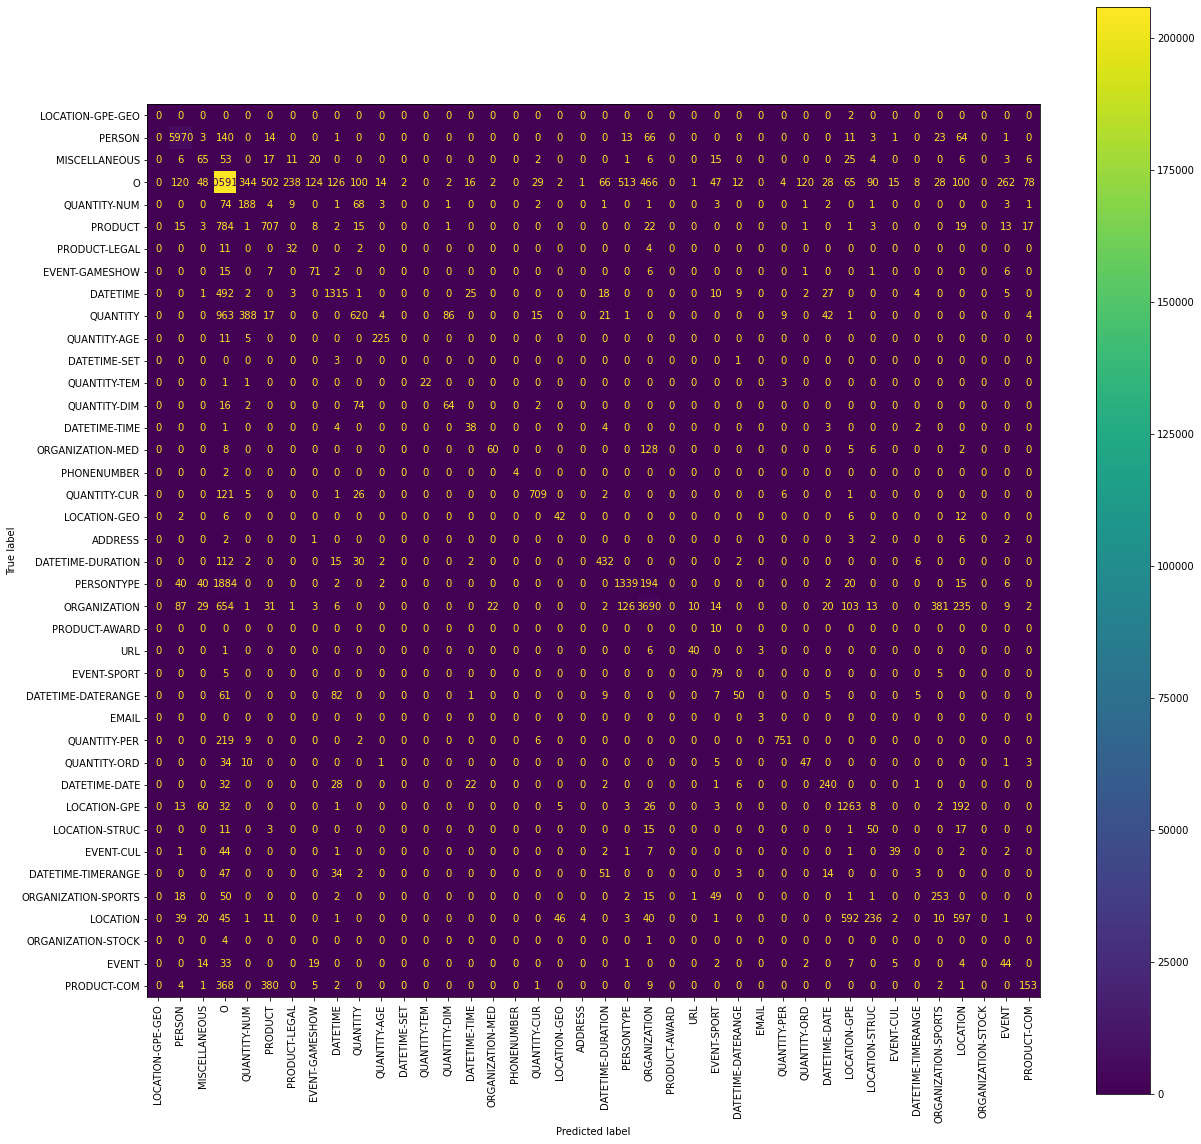

/data/hieunm/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/hieunm/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/hieunm/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
cls_report = make_report(test, preds_list)

In [3]:
# print(cls_report)